# BM-GEV fitting

This example shows the BM-GEV fitting to derive the extreme event. 

---

Load the packages

In [1]:
import pandas as pd
import pybtls as pb
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

We generate 100-year traffic data (250 business days per year) first. 

The simulation setup follows a similar logic to the previous Simulation with Traffic Generation example, but is simplified.

In [2]:
# Define the influence line
le = pb.InfluenceLine("built-in")
le.set_IL(id = 1, length = 20.0)

# Set bridge
bridge = pb.Bridge(length=20.0, no_lane=2)
bridge.add_load_effect(inf_line_surf=le)

# Set vehicle generator
garage = pb.garage.read_garage_file("./garage.txt", 4)
kernel = [[1.0, 0.08], [1.0, 0.05], [1.0, 0.02]]
vehicle_gen = pb.VehicleGenGarage(garage=garage, kernel=kernel)

# Set headway generator
headway_gen = pb.HeadwayGenFreeflow()

# Set lane flow compositions
normalized_hourly_flow_truck = [0.019947, 0.019947, 0.019947, 0.019947, 0.019947, 0.031915, 0.059840, 0.059840, 0.059840, 0.055851, 0.046543, 0.046543, 0.046543, 0.046543, 0.046543, 0.055851, 0.055851, 0.055851, 0.055851, 0.046543, 0.046543, 0.031915, 0.031915, 0.019947]
normalized_hourly_flow_car = [0.005721, 0.005721, 0.005721, 0.005721, 0.005721, 0.014874, 0.088673, 0.145881, 0.117277, 0.061785, 0.037185, 0.037185, 0.037185, 0.037185, 0.037185, 0.061785, 0.061785, 0.061785, 0.061785, 0.037185, 0.037185, 0.014874, 0.014874, 0.005721]

lfc_1 = pb.LaneFlowComposition(lane_index=1, lane_dir=1)
lfc_1.assign_lane_data(
    hourly_truck_flow = [
        round(i * 2500) for i in normalized_hourly_flow_truck
    ], 
    hourly_car_flow = [
        round(i * 14000) for i in normalized_hourly_flow_car
    ],
    hourly_speed_mean = [80 / 3.6 * 10] * 24,  # in dm/s
    hourly_speed_std = [5.0] * 24,  # in dm/s
)

lfc_2 = pb.LaneFlowComposition(lane_index=2, lane_dir=1)
lfc_2.assign_lane_data(
    hourly_truck_flow = [
        round(i * 625) for i in normalized_hourly_flow_truck
    ],
    hourly_car_flow = [
        round(i * 14000) for i in normalized_hourly_flow_car
    ],
    hourly_speed_mean = [80 / 3.6 * 10] * 24,  # in dm/s
    hourly_speed_std = [10.0] * 24,  # in dm/s
)    

# Set traffic generator
traffic_gen = pb.TrafficGenerator(no_lane=2)
traffic_gen.add_lane(vehicle_gen=vehicle_gen, headway_gen=headway_gen, lfc=lfc_1)
traffic_gen.add_lane(vehicle_gen=vehicle_gen, headway_gen=headway_gen, lfc=lfc_2)

# Selet outputs
output_config = pb.OutputConfig()
output_config.set_BM_output(
    write_summary = True,
    block_size_days = 250,
)

# Create and run the simulation
sim_task = pb.Simulation("./temp")
sim_task.add_sim(
    bridge = bridge,
    traffic = traffic_gen,
    no_day = 250*100,
    output_config = output_config,
    time_step = 0.1,
    tag = "Case5",
)
sim_task.run(no_core = 1)

# Read the output data
example_output = sim_task.get_output()
BM_output = example_output["Case5"].read_data("BM_summary")["BM_S_20_Eff_1"]

Make a plot to the BM data. 

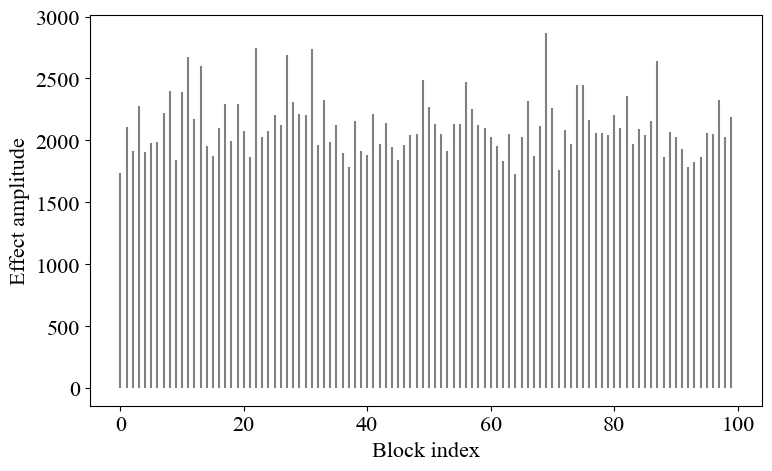

In [3]:
pb.plot.plot_BM_S(BM_output)

Make a fit to the BM data with GEV distribution.

In [12]:
def fit_gev_exceedances(BM_data: pd.Series):
    # Fit GEV: returns shape c=-xi, loc=mu, scale=sigma
    c, mu, sigma = genextreme.fit(BM_data)
    xi = -c
    return xi, mu, sigma


def return_level(T, mu, sigma, xi):
        y = -np.log(1 - 1.0 / T)
        if np.isclose(xi, 0.0):
            return mu - sigma * np.log(np.log(1 / (1 - 1.0 / T)))  # = mu - sigma*log(y)
        return mu + (sigma / xi) * (y ** (-xi) - 1)


def plot_BM_GEV_fitting(BM_data: pd.Series, mu: float, sigma: float, xi: float):

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.rcParams["mathtext.fontset"] = "stix"

    plt.figure(figsize=(8, 5))

    plt.hist(BM_data, bins=40, density=True, color="#AAAAAA", edgecolor="gray", alpha=0.8, label="Annual maximum events")

    plt.xlabel("Mid-Span Bending Moment (kNm)")
    plt.ylabel("Density")

    # Fitted GEV PDF
    if np.isclose(xi, 0.0):
        x = np.linspace(BM_data.min(), BM_data.max(), 500)
    else:
        if xi > 0.0:
            x = np.linspace(mu - sigma / xi, BM_data.max(), 500)
        elif xi < 0.0:
            x = np.linspace(BM_data.min(), mu + sigma / abs(xi), 500)

    pdf = genextreme.pdf(x, -xi, loc=mu, scale=sigma)
    plt.plot(x, pdf, color="black", lw=2, label="GEV distribution fitted")
    
    plt.legend()
    plt.tight_layout()
    plt.show()

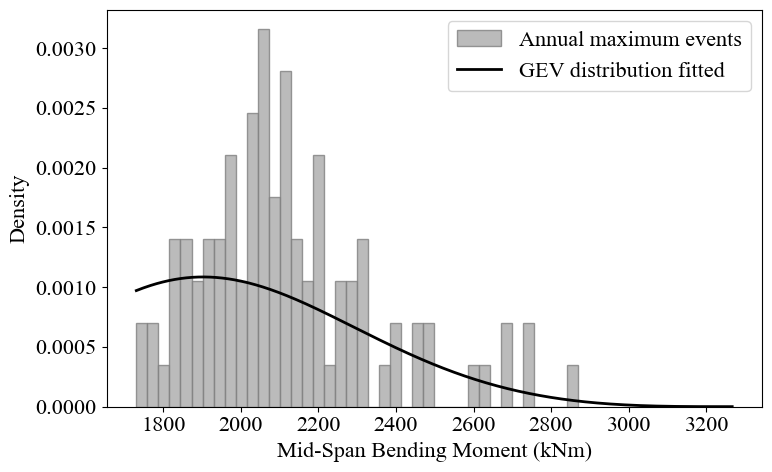

Fitted GEV distribution parameters:
xi: -0.2400, mu: 1810, sigma: 350


In [13]:
BM_data = BM_output.iloc[:, 1:]
BM_data = BM_data.max(axis=1)

xi, mu, sigma = fit_gev_exceedances(BM_data)
plot_BM_GEV_fitting(BM_data, mu, sigma, xi)

print("Fitted GEV distribution parameters:")
print(f"xi: {xi:.4f}, mu: {mu:.0f}, sigma: {sigma:.0f}")

Finally, we can use the fitted GEV parameters to estimate the extreme value for a 100-year event.

In [9]:
rl_100 = return_level(100, mu, sigma, xi)
print(f"Extreme value for 100-year event: {rl_100:.0f} kNm")

Extreme value for 100-year event: 2784 kNm
